
### Examining racial discrimination in the US job market

#### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

#### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes.

#### Exercise
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value.
   4. Discuss statistical significance.

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
%matplotlib inline
from __future__ import division
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0,5.0)
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')
print "Total count: ",len(data)
print "race == 'b': ",len(data[data.race=='b'])
print "race == 'w': ",len(data[data.race=='w'])

Total count:  4870
race == 'b':  2435
race == 'w':  2435


In [3]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1,0,1,0,0,0,0,0,0,
1,b,1,3,3,6,0,1,1,0,316,...,1,0,1,0,0,0,0,0,0,
2,b,1,4,1,6,0,0,0,0,19,...,1,0,1,0,0,0,0,0,0,
3,b,1,3,4,6,0,1,0,1,313,...,1,0,1,0,0,0,0,0,0,
4,b,1,3,3,22,0,0,0,0,313,...,1,1,0,0,0,0,0,1,0,Nonprofit


In [4]:
# number of callbacks and proportion of callbacks
print "Callback count for black-sounding names: ",sum(data[data.race=='b'].call)
print "Callback proportion for black-sounding names: ",sum(data[data.race=='b'].call)/len(data[data.race=='b'])
print "Callback count for white-sounding names: ",sum(data[data.race=='w'].call)
print "Callback proportion for white-sounding names: ",sum(data[data.race=='w'].call)/len(data[data.race=='w'])

Callback count for black-sounding names:  157.0
Callback proportion for black-sounding names:  0.064476386037
Callback count for white-sounding names:  235.0
Callback proportion for white-sounding names:  0.0965092402464


The outcome variable here is binary, so this might be treated in several ways. First, it might be possible to apply the normal approximation to the binomial distribution. In this case, the distribution proportions is $\mathcal{N}(np,np(1-p))$

There are a number of guidelines as to whether this is a suitable approximation (see [Wikipedia](https://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation) for a list of such conditions), some of which include:

* n > 20 (or 30)
* np > 5, np(1-p) > 5 (or 10)

But these conditions can be roughly summed up as not too small of a sample and an estimated proportion far enough from 0 and 1 that the distribution isn't overly skewed. If the normal approximation is reasonable, a z-test can be used, with the following standard error calculation:

$$SE = \sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n_1}+\frac{1}{n_2}\right)}$$

where $$\hat{p}=\frac{np_1+np_2}{n_1+n_2}$$

giving

$$z = \frac{p_1-p2}{SE}$$

In [5]:
xb = sum(data[data.race=='b'].call)
nb = len(data[data.race=='b'])
xw = sum(data[data.race=='w'].call)
nw = len(data[data.race=='w'])
pHat = (nb*(xb/nb) + nw*(xw/nw))/(nb+nw)
se = np.sqrt(pHat*(1-pHat)*(1/nb + 1/nw))
z = (xb/nb -xw/nw)/se
print "z-score:",round(z,3),"p =", round(stats.norm.sf(abs(z))*2,6)

z-score: -4.108 p = 4e-05


So, the difference in probability of a call-back is statistically significant here.

Plotting the distribution for call-backs with black-sounding names, it looks fairly symmetrical and well-behaved, so it's quite likely that the normal approximation is fairly reasonable here.

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


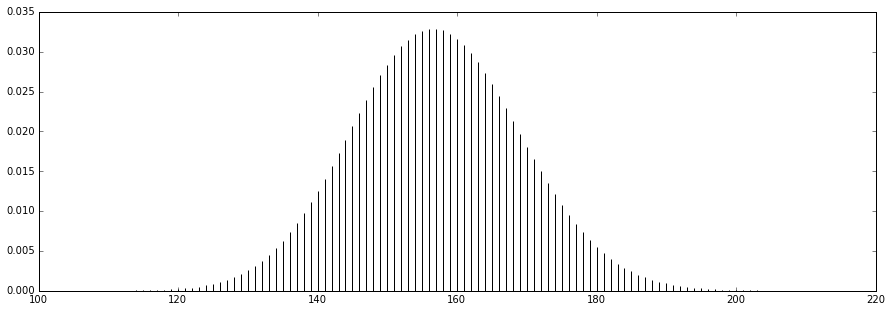

In [6]:
pb = xb/nb
x = np.arange(110,210)
matplotlib.pyplot.vlines(x,0,stats.binom.pmf(x,nb,pb))

# Alternatives

Because the normal distribution is only an approximation, the assumptions don't always work out for a particular data set. There are several methods for calculating confidence intervals around the estimated proportion. For example, with a significance level of $\alpha$, the Jeffrey's interval is defined as the $\frac{\alpha}{2}$ and 1-$\frac{\alpha}{2}$ quantiles of a beta$(x+\frac{1}{2}, n-x+\frac{1}{2})$ distribution. Using scipy:

In [7]:
intervalB = (stats.beta.ppf(0.025,xb+0.5,nb-xb+0.5),stats.beta.ppf(0.975,xb+0.5,nb-xb+0.5))
intervalW = (stats.beta.ppf(0.025,xw+0.5,nw-xw+0.5),stats.beta.ppf(0.975,xw+0.5,nw-xw+0.5))
print "Interval for black-sounding names: ",map(lambda x: round(x,3),intervalB)
print "Interval for white-sounding names: ",map(lambda x: round(x,3),intervalW)

Interval for black-sounding names:  [0.055, 0.075]
Interval for white-sounding names:  [0.085, 0.109]


The complete lack of overlap in the intervals here implies a significant difference with $p\lt 0.05$ ([Cumming & Finch,2005](http://www.apastyle.org/manual/related/cumming-and-finch.pdf)). Given that this particular interval can be interpreted as a Bayesian credible interval, this is a fairly comfortable conclusion.

### Calculating credible intervals using Markov Chain Monte Carlo
Slightly different method of calculating approximately the same thing (the beta distribution used above the posterior distribution given given the observations with a Jeffreys prior):

In [8]:
import pystan

In [9]:
modelCode = '''
data {
  int<lower=0> N; 
  int<lower=1,upper=2> G[N];
  int<lower=0,upper=1> y[N];
} 
parameters {
  real<lower=0,upper=1> theta[2];
} 
model {
  # beta(0.5,0.5) prior
  theta ~ beta(0.5,0.5);
  # bernoulli likelihood
  # This could be modified to use a binomial with successes and counts instead
  for (i in 1:N) 
    y[i] ~ bernoulli(theta[G[i]]);
}
generated quantities {
  real diff;
  // difference in proportions:
  diff <- theta[1]-theta[2];
}
'''

model = pystan.StanModel(model_code=modelCode)

In [10]:
dataDict = dict(N=len(data),G=np.where(data.race=='b',1,2),y=map(int,data.call))
fit = model.sampling(data=dataDict)

In [11]:
print fit

Inference for Stan model: anon_model_8b4f1e02e3c6136d2cb318fc285607be.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0]   0.06  1.5e-4 5.0e-3   0.06   0.06   0.06   0.07   0.07 1152.0    1.0
theta[1]    0.1  1.8e-4 5.9e-3   0.09   0.09    0.1    0.1   0.11 1117.0    1.0
diff      -0.03  2.3e-4 7.7e-3  -0.05  -0.04  -0.03  -0.03  -0.02 1166.0    1.0
lp__      -1358    0.03   0.98  -1361  -1358  -1358  -1357  -1357  834.0    1.0

Samples were drawn using NUTS(diag_e) at Mon Nov  9 20:23:03 2015.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


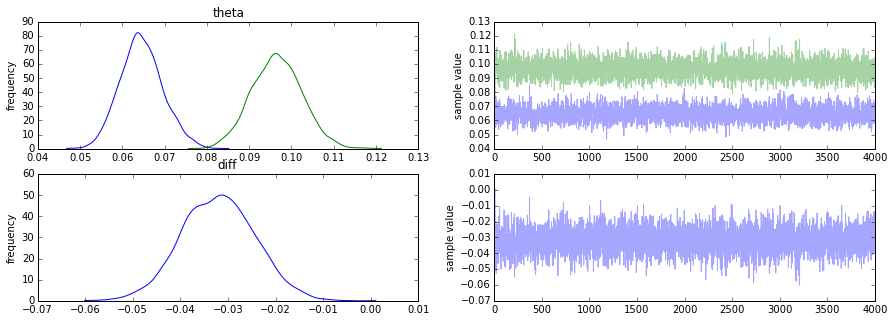

In [12]:
samples = fit.extract(permuted=True)
MCMCIntervalB = np.percentile(samples['theta'].transpose()[0],[2.5,97.5])
MCMCIntervalW = np.percentile(samples['theta'].transpose()[1],[2.5,97.5])
fit.plot().show()

Estimating rough 95% credible intervals:

In [13]:
print map(lambda x: round(x,3),MCMCIntervalB)
print map(lambda x: round(x,3),MCMCIntervalW)

[0.055, 0.075]
[0.085, 0.109]


So, this method gives a result that fits quite nicely with previous results, while allowing more flexible specification of priors.

Interval for sampled differences in proportions:

In [14]:
print map(lambda x: round(x,3),np.percentile(samples['diff'],[2.5,97.5]))

[-0.047, -0.017]


And this interval does not include 0, so that we're left fairly confident that black-sounding names get less call-backs, although the estimated differences in proportions are fairly small (significant in the technical sense isn't really the right word to describe this part).

# Accounting for additional factors:

A next step here would be to check whether other factors influence the proportion of call-backs. This can be done using logistic regression, although there will be a limit to the complexity of the model to be fit, given that the proportion of call-backs is quite small, potentially leading to small cell-counts and unstable estimates (one rule of thumb being n>30 per cell is reasonably safe).

In [15]:
data.columns

Index([u'id', u'ad', u'education', u'ofjobs', u'yearsexp', u'honors',
       u'volunteer', u'military', u'empholes', u'occupspecific', u'occupbroad',
       u'workinschool', u'email', u'computerskills', u'specialskills',
       u'firstname', u'sex', u'race', u'h', u'l', u'call', u'city', u'kind',
       u'adid', u'fracblack', u'fracwhite', u'lmedhhinc', u'fracdropout',
       u'fraccolp', u'linc', u'col', u'expminreq', u'schoolreq', u'eoe',
       u'parent_sales', u'parent_emp', u'branch_sales', u'branch_emp', u'fed',
       u'fracblack_empzip', u'fracwhite_empzip', u'lmedhhinc_empzip',
       u'fracdropout_empzip', u'fraccolp_empzip', u'linc_empzip', u'manager',
       u'supervisor', u'secretary', u'offsupport', u'salesrep', u'retailsales',
       u'req', u'expreq', u'comreq', u'educreq', u'compreq', u'orgreq',
       u'manuf', u'transcom', u'bankreal', u'trade', u'busservice',
       u'othservice', u'missind', u'ownership'],
      dtype='object')

In [16]:
# The data is balanced by design, and this mostly isn't a problem for relatively simple models.
# For example:
pd.crosstab(data.computerskills,data.race)

race,b,w
computerskills,,
0,408,466
1,2027,1969


In [17]:
import statsmodels.formula.api as smf

Checking to see if computer skills have a significant effect on call-backs:

In [18]:
glm = smf.Logit.from_formula(formula="call~race+computerskills",data=data).fit()
glm.summary()

Optimization terminated successfully.
         Current function value: 0.277880
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   call   No. Observations:                 4870
Model:                          Logit   Df Residuals:                     4867
Method:                           MLE   Df Model:                            2
Date:                Mon, 09 Nov 2015   Pseudo R-squ.:                0.007469
Time:                        20:23:07   Log-Likelihood:                -1353.3
converged:                       True   LL-Null:                       -1363.5
                                        LLR p-value:                 3.779e-05
==================================================================================
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         -2.4772      0.132    -18.728      0.000        -2.736    -2.218
race[T.w]          0.4324      0.107      4.025      0.000         0.222     0.643
computerskills    -0.2418      0.129     -1.875      0.061        -0.495     0.011
==================================================================================
"""

The effect might be described as [marginal](https://mchankins.wordpress.com/2013/04/21/still-not-significant-2/), but probably best not to over-interpret. But maybe the combination of race and computer skills makes a difference? Apparently not in this data (not even an improvement to the model log-likelihood or other measures of model fit):

In [19]:
glm2 = smf.Logit.from_formula(formula="call~race*computerskills",data=data).fit()
glm2.summary()

Optimization terminated successfully.
         Current function value: 0.277831
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   call   No. Observations:                 4870
Model:                          Logit   Df Residuals:                     4866
Method:                           MLE   Df Model:                            3
Date:                Mon, 09 Nov 2015   Pseudo R-squ.:                0.007645
Time:                        20:23:20   Log-Likelihood:                -1353.0
converged:                       True   LL-Null:                       -1363.5
                                        LLR p-value:                 0.0001133
============================================================================================
                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                   -2.5702      0.193    -13.340      0.000        -2.948    -2.193
race[T.w]                    0.5794      0.240      2.418      0.016         0.110     1.049
computerskills              -0.1268      0.213     -0.595      0.552        -0.545     0.291
race[T.w]:computerskills    -0.1850      0.268     -0.690      0.490        -0.711     0.341
============================================================================================
"""

But, there's still rather a lot of stuff left to explore in this data.